# Fisher假设检验方法用于多分类问题评分的思考
- [jupyter发布版本](http://file.loopy.tech/release/FisherScore.html)使用jupyter-notebook编译生成,也可参见[Github仓库](https://github.com/loopyme/AliTianChi/blob/master/多分类_幸福度/Fisher假设检验方法用于多分类问题评分的思考.ipynb),或可在线运行的平台:[online-playground](http://jupyter.loopy.tech:8888/notebooks/Fisher假设检验方法用于多分类问题评分的思考.ipynb),[天池实验室](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281915.0.0.30756d844eWfcf&postId=58920)

- 阅读指南:左右划切换小节,上下划查看本小节其他内容

## 一. 问题的发现
在阿里天池的[幸福感预测比赛](https://tianchi.aliyun.com/competition/entrance/231702/introduction?spm=5176.12281949.1003.6.493e2448kC12t6)（实质上是个多分类预测问题）中，使用到了均方误差（MSE）评分的办法。我发现MSE虽然能表征预测结果的有效性，但实际上存在一个漏洞。

考虑一个测试集,将其2k个样本的结果作为空间$F^{2000}$下的一个基准点$Y$.在提交了十个结果以后,用这十个点确定一个平面(线性子空间)$F^{10}$,再从$Y$向$F^{10}$作投影,投影点$P$即为已知空间$F^{10}$中最优的一点。取$P$会导致MSE急剧下降，原理在于,这个算法使用测试集得分对结果的有效性进行校正(实际上会达到最优),而只依赖于结果的无偏性。基于这个思路，我已实现了算法，并证明这个漏洞可以被利用，在上文提到的这场比赛中获得了线上MSE=0.1971的成绩，（如果有效的话）在比赛排名第2，与其他0.4+的得分相比，属于异常数据。并由于疏忽，于2019-05-12将结果提交到了比赛平台，目前正在联系平台寻找[删除成绩的办法](https://tianchi.aliyun.com/forum/issueDetail?spm=5176.12586969.1002.36.52a16cd0kzuT2n&postId=58688)。

由此可见，在数据挖掘的离线赛中，均方误差（MSE）评分法存在较大的漏洞。

## 二. Fisher假设检验方法的思考
为了填补这个漏洞，恰逢我的概率论老师荣sir要求我们阅读罗纳德.费舍尔著作的"6 Mathematics of a Lady Tasting Tea"，我开始思考Fisher假设检验的思路能否用于多分类预测问题比赛的评分？

仿照费舍尔的思路，我完成了"Mathematics of a Model Predicting Happiness"的思考。


## 三.Mathematics of a Model Predicting Happiness
### 3.1实验说明
一个Xgboost模型声称，通过阅读一个人关于生活的问卷，它可以辨别出那个人的幸福程度。我们将考虑设计一个实验，通过这个实验来验证这一论断。为此，我们首先提出一种简单的实验形式，研究这一实验中的限制和特点。

我们的实验包括1000条样本数据，然后随机地把它们呈现给一个Xgboost模型进行判断。它已被告知提前测试将包括什么,也就是说,它已通过预先学习（fit）另外的9000条样本数据，知晓各特征之间的相关关系，知道它应通过哪些输入来判断Happiness的分类结果（在这个数据集中Happiness被分为0到5，共六个等级）

In [1]:
# 实验准备
import pandas as pd
from xgboost import XGBClassifier
from scipy.special import comb
from math import *
from sklearn.metrics import mean_squared_error,accuracy_score
import warnings
warnings.filterwarnings("ignore")

# 准备数据集:我简化的使用[0:1000]做测试集,[1000:]做训练集
data = pd.read_csv('./data/happiness_train_complete.csv',encoding='gbk').drop(['survey_time',"property_other","invest_other","edu_other"],axis=1)
data = data.fillna(-8)[data['happiness']>=0]

# 准备模型
model = XGBClassifier().fit(data.drop(['happiness'],axis=1).iloc[1000:],data["happiness"].iloc[1000:])

# 分割数据集
data = data.iloc[:1000]

# 使用模型作出预测
pred = pd.DataFrame([model.predict(data.drop(['happiness'],axis=1)),data['happiness']],index=['pred','true']).T

# 数据集描述
count = [[],[],[],[]]
for i in range(1,6):
    count[0].append(data[data["happiness"]==i]["happiness"].count())
    count[1].append(pred[pred['pred']==i]['pred'].count())
    count[2].append(pred[pred['true']==i][pred['pred']==pred['true']]['pred'].count())
    count[3].append(pred[pred['true']==i][pred['pred']!=pred['true']]['pred'].count())

# 使用模型作出预测
pd.DataFrame([model.predict(data.drop(['happiness'],axis=1)),data['happiness']],index=['pred','true'])

#输出
count_log = pd.DataFrame(count,index = ["真实频数","预测频数","正确判断数","错误判断数"],columns = [1,2,3,4,5])
count_log

,1,2,3,4,5
真实频数,17,53,151,604,175
预测频数,4,37,20,892,47
正确判断数,3,14,10,575,28
错误判断数,14,39,141,29,147


### 3.2解释及其依据

> 费舍尔在他的文章中提出:频率分布适合一个分类结果纯粹是偶然的.如果没有辨别能力,实验的结果将完全由随机的概率决定

在考虑任何设想的实验设计是否合适时，总是需要预测实验的可能结果，并决定对每一个结果应作何种解释。此外，我们必须知道这种解释要用什么论据来支持。在目前的情况下，我们可以这样说:从2000个样本中选出其中的17个Happiness=0的对象有$C_{1000}^{17}$种方法。对一种没有分类效果的模型来说,它正确选出这17个对象的概率是$\dfrac{1}{C_{1000}^{17}}\approx4.08e^{-37}$.

In [2]:
1/comb(1000, 17)


4.078121130799551e-37

### 3.3零假设
 - $H_0$:这个Xgboost模型不能通过阅读一个人关于生活的问卷，辨别出那个人的幸福程度。

### 3.4检验

> 费舍尔在他的文章中,主要通过当前观察到的事件的极端程度(概率),来对事件空间的分布进行预测,所以既然要考察当前观察到的事件有多么极端，那就不仅要知道该事件个体点发生的概率，还要知道它在整个事件空间中所处的位置，即比这个事件更极端的事件空间的总概率,考虑到事件是离散的,可以用$\sum$来解决,这里我暂时将它称为极限概率

1. 如果这个xgboost模型选出了17个Happiness=0的对象:上面我们计算出误打误撞获得正确结果的概率是一个极小的值,这使得如果这个模型能精确的选出这17个Happiness=0的对象,那么我们就有很大的把握说它能够辨别出某个人的幸福程度是否为1.但如果,这个模型只选出了3个正确答案.那么误打误撞选出3个正确答案的可能性则为:$\dfrac{C_{17}^3\times C_{983}^{14}}{C_{1000}^{17}}\approx0.00228$,也就能计算出极限概率$\sum_{i=3}^{17}{\dfrac{C_{17}^i\times C_{983}^{17-i}}{C_{1000}^{17}}}\approx0.0024$,这就是说只有0.0024的可能性,在$H_1$成立时,事件会落到这个极端事件空间里



2. 可是,这个xgboost模型只选出了4个Happiness=0的对象:只选出了4个并正确3个的单事件概率:$\dfrac{C_{4}^3\times C_{996}^{1}}{C_{1000}^{4}}\approx9.62e^{-8}$,极限概率:$\sum_{i=3}^{4}{\dfrac{C_{4}^i\times C_{996}^{4-i}}{C_{1000}^{4}}}\approx9.62e^{-8}$

这两个极限概率都很小,能够支撑起$H_1$的判断,但如果需要建立一个量化的评判标准,选那个比较好?

In [3]:
# 极限概率计算函数
def calculate_p(count_all,count_try,count_true):
    p = 0
    for i in range(count_true,count_try+1):
        p+=comb(count_try, i)*comb(count_all-count_try, count_try-i)/comb(count_all, count_try)
    return p
calculate_p(1000,17,3),calculate_p(1000,4,3)

(0.002399205081394864, 9.621623963648032e-08)

### 3.5评判标准

我考虑到:如果采用检验2中的方法,实质上每个分类的事件空间相互挤压,发生了较大变形,可能会造成频率信息的失真,所以检验1中的计算方法更加合理.于是我按照检验1中的计算方法，考虑六个分类，将这个评判的量化标准表示为:
$${pscore}=-\sum_{i=1}^{S_{cat}}ln({calculate_p}(S_{sample},S_i,S_i^*))$$
$${calculate_p}(S_{sample},S_i,S_i^*)=\sum_{i=S_i^*}^{S_i}{\dfrac{C_{S_i}^i\times C_{S_{sample}-S_i}^{S_i-i}}{C_{S_{sample}}^{S_i}}}$$

联立起来就是：
$${pscore}=-\sum_{i=1}^{S_{cat}}ln(\sum_{i=S_i^*}^{S_i}{\dfrac{C_{S_i}^i\times C_{S_{sample}-S_i}^{S_i-i}}{C_{S_{sample}}^{S_i}}})$$

|符号|意义|
| -------- | -------- |
| $pscore$ | 模型得分 |
| $S_{cat}$ | 分类总数 |
| $ln$ | 自然对数函数 |
| ${calculate_p}$ | 极限概率计算函数 |
| $S_{sample}$ | 样本容量 |
| $S_i$ | (真实值中)第i类中的正确分类个数 |
| $S_i^*$ | (真实值中)第i类个数 |

这个得分表征了不具预测能力的模型获得这个结果及更优结果的可能性大小(或者预测的事件及更优事件占全体事件空间的比例),其值为一个正数,越大表示越优秀.

也就是说,这样一个模型能把事件空间$F$的所有可能性坍缩到$e^{-score}$倍大小的空间中.

In [4]:
def score(y_pred,y_true):
    limit = [y_true.min(),y_true.max()]
    s_sample = y_true.count()
    s_cat = limit[1]-limit[0]
    score = 0
    
    data = pd.DataFrame([y_pred,y_true],index=['pred','true']).T
    
    for i in range(limit[0],limit[1]+1):
        s_i_ = data[data['true']==i]['true'].count()
        s_i =  data[data['true']==i][data['pred']==data['true']]['pred'].count()
        score += log(calculate_p(s_sample,s_i_,s_i))
    return -score

In [5]:
score(pred['pred'],pred['true']),score(pred['true'],pred['true'])

(474.99645867621354, 1837.2800383353233)

In [6]:
%%timeit
score(pred['pred'],pred['true'])

77.6 ms ± 7.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
mean_squared_error(pred['pred'],pred['true'])

249 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
accuracy_score(pred['pred'],pred['true'])

373 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


计算出这个Xgboost模型的score是474,由此,我们可以拒绝零假设$H_0$，即认为这个模型具有预测幸福度的能力.同时,我们也能计算出最优情况下score为1837.

p-score是很直观的，看下面的Venn图，是一个p-score=1和p-score=2的预测结果的示意图。

预测结果，及比其更优的预测结果组成了预测事件空间；而全体事件，则组成了事件空间。p-score就表征了模型预测导致的事件空间可能性坍缩比例。由此可知，p-score越大，预测事件空间越小，就越精准。因此，p-score能量化的表现预测效果：我们能够明确的说p-score=2的模型比p-score=1的模型预测效果好$e^{2-1}=e$倍(自然对数)。

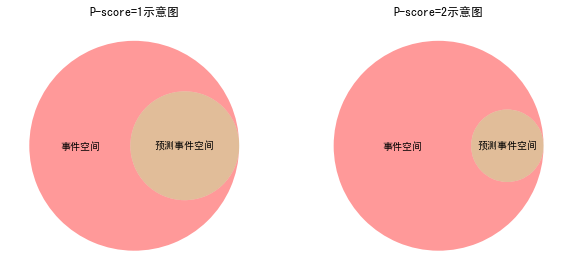

In [ ]:
# 绘图
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline
e=2.718

fig=plt.figure(figsize=(20,10))

ax = fig.add_subplot(221)
plt.title("P-score=1示意图")
v = venn2(subsets=(e, 0, 1), set_labels=('', ''))
v.get_label_by_id('10').set_text('事件空间')
v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('预测事件空间')

ax2 = fig.add_subplot(211)
plt.title("P-score=2示意图")
v = venn2(subsets=(e**2, 0, 1), set_labels=('', ''))
v.get_label_by_id('10').set_text('事件空间')
v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('预测事件空间')
fig.show()

## 四. 总结

我认为这是一个比MSE更有效的针对多分类问题的评判标准。

p-score的优势在于，它能直观的表现模型的预测能力。我们能够明确的说p-score=2的模型比p-score=1的模型预测效果好$e^{2-1}=e$倍(自然对数)，但却不能通过MSE，召回率或准确率来量化的比较模型的预测能力，也就是没有办法说清楚MSE=0.01与MSE=0.04的模型相比预测效果到底优了多少。而召回率，准确率也是这样，你能说100%准确率的模型比50%准确率的具体好了多少吗？

所以我认为p-score更符合概率论，或数据统计中的表达方式。

同时，它也能避免最初提到的赛制漏洞，我没有想到能根据p-score来调整模型的方法，而诸如MSE，召回率，准确率，我认为都是利用得分参与模型调优的。（MSE的利用方法已提到，而召回率，准确率我猜测能通过回归预测各样本的分类置信度和得分来调整结果）MSE等判分方法，都只防君子，不防小人。禁止通过考试答案来准备考试是有效的，但禁止通过以前的考试分数来准备考试是难以操作和实现的。

p-score的缺陷：
 - 没有考虑分类结果的逻辑相邻：分类结果数值上的相邻导致了逻辑上的相邻，但这是没有被考虑到的。（例如：把幸福等级为"很幸福"的样本分为"比较幸福"与"不幸福"都是错误答案，但错误程度是不同的。）
 - 计算复杂度高，未经优化的代码在上面的测试中（1000条数据）每次运行需要39.4 ms(± 72.8 µs),平均运行时间是比MSE方法的394倍，是accuracy方法的261倍。但可能在优化后会提升效率，展示用代码实用性较低。
 - 一点也不优美:需要想办法优化
 - 在大数据集上存在计算溢出的问题

参考文献：6 Mathematics of a Lady Tasting Tea By SIR RONALD A. FISHER Uddrag af James R. Newman, The World of Mathematics, Volume III., Part VIII, Statistics and the Design of Experiments (New York, Simon & Schuster, 1956), pp. 1514-1521 
>这其实是我概率论课程的作业，由于时间限制，我没有查阅足够的文献，这个notebook仅为我阅读费舍尔著作的论文时顺手实现的一点想法。